# PBL01

Disciplina: [COQ878 - Química Quântica Computacional](https://github.com/elvissoares/COQ878-QuiQuaComp/tree/main)

Aluna: [Suzane Carvalho Rufino dos Santos](https://github.com/suzanecr) 

Contato: [suzane@peq.coppe.ufrj.br](mailto:suzane@peq.coppe.ufrj.br) - Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil

---

In [2]:
import os

os.environ['VASP_PP_PATH'] = '/home/suzanecr/Programs/vasp-6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std_gpu'
os.environ['NO_STOP_MESSAGE'] = '1' 


from ase.calculators.vasp import Vasp

from ase import Atoms
from ase.io import write, read
from ase.visualize import view
from ase.thermochemistry import IdealGasThermo

import numpy as np

# COOH(ads) → CO₂(ads) + H(ads) em Pt(111)

**Objetivo:** Calcular o $\Delta E$ e $\Delta H$ de adsorção para os reagentes e produtos da reação alvo.

Reações de Adsorção Elementares

$ COOH(g) + ^* \rightleftarrows COOH^*$ (1) - utilizar o carboxyl-trans

$ CO_2(g) + * \to CO_2*$ (2) 

$ H_2(g) + * \to 2 H*$ (3) 

Catalisador: Pt(111)


**Ref:** 
- Grabow, L. C., Gokhale, A. A., Evans, S. T., Dumesic, J. A., & Mavrikakis, M. (2008). _Mechanism of the water gas shift reaction on Pt: First principles, experiments, and microkinetic modeling._ The Journal of Physical Chemistry C, 112(12), 4608-4617. https://pubs.acs.org/doi/pdf/10.1021/jp7099702
- Gokhale, A. A., Dumesic, J. A., & Mavrikakis, M. (2008). _On the mechanism of low-temperature water gas shift reaction on copper._ Journal of the American Chemical Society, 130(4), 1402-1414. https://pubs.acs.org/doi/pdf/10.1021/ja0768237

**Passo a passo para os cálculos:**

1. Modelar a superfície do catalisador e otimizar sua geometria

2. Adsorver o COOH-trans

    2.1. Calcular a Energia Potencial

    2.2. Calcular a Energia de Adsorção na superfície ($\Delta E$)

    2.3. Calcular as Frequências Vibracionais

    2.4. Calcular a Entalpia do $COOH^*$ (usando o $\texttt{IdealGasThermo}$)

    2.5. Calcular o $\Delta H$

3. Adsorver o $CO_2$

    3.1. Calcular a Energia Potencial

    3.2. Calcular a Energia de Adsorção na superfície ($\Delta E$)

    3.3. Calcular as Frequências Vibracionais

    3.4. Calcular a Entalpia do $CO_2^*$ (usando o $\texttt{IdealGasThermo}$)

    3.5. Calcular o $\Delta H$

4. Adsorver o H

    4.1. Calcular a Energia Potencial

    4.2. Calcular a Energia de Adsorção na superfície ($\Delta E$)

    4.3. Calcular as Frequências Vibracionais

    4.4. Calcular a Entalpia do H* (usando o $\texttt{IdealGasThermo}$)

    4.5. Calcular o $\Delta H$

**OBS:**

 5. Adsorver simultaneamente o $CO_2$ e o H na superfície

    5.1. Calcular a Energia de Adsorção de ambas as espécies na superfície ($\Delta E$)

    5.2. Calcular o $\Delta H$ de ambas as espécies na superfície

## Inputs (T, P)

In [3]:
P = 101325. # Pa
T = 298.15 # K

## Catalisador de Pt(111)

In [4]:
from ase.lattice.cubic import FaceCenteredCubic

# bulk system
Pt_crystal = FaceCenteredCubic(size=(1, 1, 1), symbol='Pt', latticeconstant=3.967, pbc=True)

calc_relax = Vasp(directory='Pt_relax',
                xc='PBE',
                kpts=[6, 6, 6],  
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                isif=7, ibrion=2, nsw=100, 
                atoms=Pt_crystal
                )
calc_relax.calculate(Pt_crystal) 

E_Pt = Pt_crystal.get_potential_energy()

a0_Pt = Pt_crystal.cell.cellpar()[0]

print(f'Optimized energy of Pt: {E_Pt:.3f} eV')
print(f"Lattice length: {a0_Pt:.3f} Å")

Optimized energy of Pt: -24.458 eV
Lattice length: 3.967 Å


In [5]:
from ase.build import fcc111

# Superfície Pt111
Pt111_slab = fcc111("Pt", size=(2,2,3), a=a0_Pt)
Pt111_slab.center(vacuum=5.0, axis=2)
Pt111_slab.pbc = True

calc_relax = Vasp(directory='Pt111_slab_relax',
                xc='PBE',
                kpts=[6, 6, 1],  
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                ibrion=-1, 
                atoms=Pt111_slab
                )
calc_relax.calculate(Pt111_slab) 

E_Pt111 = Pt111_slab.get_potential_energy()

print(f'Optimized energy of Pt111: {E_Pt111:.3f} eV')

Optimized energy of Pt111: -67.924 eV


## Espécies Gasosas

COOH_trans

In [6]:
COOH = Atoms('CO2H',
                   positions=[
                       [ 0.000,  0.000,  0.000],   # C
                       [ 1.220,  0.000,  0.000],   # O carbonílico
                       [-1.180,  0.000,  0.000],   # O do grupo OH
                       [-1.180,  0.000,  0.970]    # H do grupo OH
                   ]) # geometria otimizada com PBE

COOH.center(vacuum=6.0)  
COOH.pbc = True

calc_relax = Vasp(
    directory='COOH_relax',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-6, ediffg=-0.01,
    isif=2, ibrion=2, nsw=100,
    nelm=100,
    lwave=True, lcharg=True, lvtot=True,
    atoms=COOH
)
calc_relax.calculate(COOH) 

E_COOH = COOH.get_potential_energy()

print(f'Optimized energy of COOH: {E_COOH:.3f} eV')

Optimized energy of COOH: -23.931 eV


In [7]:
calc_vib = Vasp(
    directory='COOH_vib',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=6,           
    lreal=False,
    lwave=False, lcharg=False,
    atoms=COOH
)

calc_vib.calculate(COOH)

vib_COOH = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_COOH.get_frequencies()

print(f'Vibrational frequencies of COOH (cm⁻¹):')
vib_energies_COOH = []
for freq in freqs:
    if freq.real > 100:                                 # TROCAMOS
        vib_energy = (freq.real * 1.23981e-4)  
        vib_energies_COOH.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of COOH (cm⁻¹):
f_v: 552.059 cm⁻¹, E_v: 0.068 eV
f_v: 564.537 cm⁻¹, E_v: 0.070 eV
f_v: 1002.419 cm⁻¹, E_v: 0.124 eV
f_v: 1243.044 cm⁻¹, E_v: 0.154 eV
f_v: 1798.598 cm⁻¹, E_v: 0.223 eV
f_v: 3359.170 cm⁻¹, E_v: 0.416 eV


In [8]:
COOH_thermo = IdealGasThermo(vib_energies=vib_energies_COOH,
                        potentialenergy=E_COOH, atoms=COOH,
                        geometry='nonlinear', symmetrynumber=2, spin=0)

G_COOH = COOH_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_COOH = COOH_thermo.get_enthalpy(temperature=T, verbose=False)

print(f'ΔH COOH  = {H_COOH:.3f} eV')

ΔH COOH  = -23.289 eV


$CO_2$

In [9]:
CO2 = Atoms('CO2',
            positions=[[0.000, 0.000, 0.000],
                       [0.000, 0.000, 1.177],
                       [0.000, 0.000, -1.177]]) 
CO2.center(vacuum=6.0)  
CO2.pbc = True

calc_relax = Vasp(
    directory='CO2_relax',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-6, ediffg=-0.01,
    isif=2, ibrion=2, nsw=100,
    nelm=100,
    lwave=True, lcharg=True, lvtot=True,
    atoms=CO2
)
calc_relax.calculate(CO2) 

E_CO2 = CO2.get_potential_energy()

print(f'Optimized energy of CO2: {E_CO2:.3f} eV')

Optimized energy of CO2: -22.960 eV


In [10]:
calc_vib = Vasp(
    directory='CO2_vib',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=6,           
    lreal=False,
    lwave=False, lcharg=False,
    atoms=CO2
)

calc_vib.calculate(CO2)

vib_CO2 = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_CO2.get_frequencies()

print(f'Vibrational frequencies of CO2 (cm⁻¹):')
vib_energies_CO2 = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4) 
        vib_energies_CO2.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of CO2 (cm⁻¹):
f_v: 631.471 cm⁻¹, E_v: 0.078 eV
f_v: 631.471 cm⁻¹, E_v: 0.078 eV
f_v: 1317.646 cm⁻¹, E_v: 0.163 eV
f_v: 2365.938 cm⁻¹, E_v: 0.293 eV


In [11]:
CO2_thermo = IdealGasThermo(vib_energies=vib_energies_CO2,
                        potentialenergy=E_CO2, atoms=CO2,
                        geometry='linear', symmetrynumber=2, spin=0)

G_CO2 = CO2_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_CO2 = CO2_thermo.get_enthalpy(temperature=T, verbose=False)

print(f'ΔH CO2  = {H_CO2:.3f} eV')

ΔH CO2  = -22.555 eV


$H_2$

In [12]:
H2 = Atoms('H2',
            positions=[[0.000, 0.000, 0.000],
                       [0.000, 0.000, 0.740]]) 
H2.center(vacuum=6.0)  
H2.pbc = True

calc_relax = Vasp(
    directory='H2_relax',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-6, ediffg=-0.01,
    isif=2, ibrion=2, nsw=100,
    nelm=100,
    lwave=True, lcharg=True, lvtot=True,
    atoms=H2
)
calc_relax.calculate(H2) 

E_H2 = H2.get_potential_energy()

print(f'Optimized energy of H2: {E_H2:.3f} eV')

Optimized energy of H2: -6.766 eV


In [13]:
calc_vib = Vasp(
    directory='H2_vib',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=6,           
    lreal=False,
    lwave=False, lcharg=False,
    atoms=H2
)

calc_vib.calculate(H2)

vib_H2 = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_H2.get_frequencies()

print(f'Vibrational frequencies of H2 (cm⁻¹):')
vib_energies_H2 = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4) 
        vib_energies_H2.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of H2 (cm⁻¹):
f_v: 4320.547 cm⁻¹, E_v: 0.536 eV


In [14]:
H2_thermo = IdealGasThermo(vib_energies=vib_energies_H2,
                        potentialenergy=E_H2, atoms=H2,
                        geometry='linear', symmetrynumber=2, spin=0)

G_H2 = H2_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_H2 = H2_thermo.get_enthalpy(temperature=T, verbose=False)

print(f'ΔH H2  = {H_H2:.3f} eV')

ΔH H2  = -6.409 eV


## Reação 1: Carboxyl (trans) Adsorption

$ COOH + * \to COOH*$ 

In [15]:
from ase.constraints import FixAtoms
from ase.build import add_adsorbate

# Adsorvendo a molécula de COOH na superfície Pt111

COOHads_slab = fcc111("Pt", size=(2,2,3), a=a0_Pt)
COOHads_slab.center(vacuum=5.0, axis=2)
COOHads_slab.pbc = True


COOH_trans = Atoms('CO2H',
                   positions=[
                       [ 0.000,  0.000,  0.000],   # C
                       [ 1.220,  0.000,  0.000],   # O carbonílico
                       [-1.180,  0.000,  0.000],   # O do grupo OH
                       [-1.180,  0.000,  0.970]    # H do grupo OH
                   ]) # geometria otimizada com PBE

COOH_trans.center(vacuum=6.0)  
COOH_trans.pbc = True

# COOH_trans.rotate('z', 104.46/2) # rotaciona a molécula em 60 graus em torno do eixo z


add_adsorbate(COOHads_slab,  adsorbate=COOH_trans, height=2.45, position = (4.50, 2.18), mol_index=2 )

# fixando os átomos de Pt
constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in COOHads_slab])
COOHads_slab.set_constraint([constraint])

calc_relax = Vasp(directory='Pt111_COOH_relax',
                xc='PBE',
                kpts=[6, 6, 1],  
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                isif=0, ibrion=2, nsw=100, 
                atoms=COOHads_slab
                )
calc_relax.calculate(COOHads_slab) 

E_Pt111_COOH= COOHads_slab.get_potential_energy()

print(f'Optimized energy of COOH in top position of Pt111: {E_Pt111_COOH:.3f} eV')


Optimized energy of COOH in top position of Pt111: -94.451 eV


In [16]:
E_ads_Pt111_COOH = E_Pt111_COOH - E_Pt111 - E_COOH

print(f'Adsorption energy of COOH on Pt111: {E_ads_Pt111_COOH:.3f} eV')

Adsorption energy of COOH on Pt111: -2.596 eV


In [17]:
calc_vib = Vasp(
    directory='Pt111_COOH_vib',
    xc='PBE',
    kpts=[6, 6, 1],
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=5,nfree=2, nsw=1,           
    lreal=False,lwave=False, lcharg=False,
    atoms=COOHads_slab
)

calc_vib.calculate(COOHads_slab)

vib_Pt111_COOH = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_Pt111_COOH.get_frequencies()

print(f'Vibrational frequencies of COOH on Pt111 (cm⁻¹):')

vib_energie_Pt111_COOH = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  
        vib_energie_Pt111_COOH.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of COOH on Pt111 (cm⁻¹):
f_v: 271.625 cm⁻¹, E_v: 0.034 eV
f_v: 286.934 cm⁻¹, E_v: 0.036 eV
f_v: 480.636 cm⁻¹, E_v: 0.060 eV
f_v: 566.542 cm⁻¹, E_v: 0.070 eV
f_v: 647.821 cm⁻¹, E_v: 0.080 eV
f_v: 981.486 cm⁻¹, E_v: 0.122 eV
f_v: 1188.687 cm⁻¹, E_v: 0.147 eV
f_v: 1695.765 cm⁻¹, E_v: 0.210 eV
f_v: 3486.215 cm⁻¹, E_v: 0.432 eV


In [18]:
COOH_Pt111_thermo = IdealGasThermo(vib_energies=vib_energie_Pt111_COOH,
                        potentialenergy=E_Pt111_COOH, atoms=COOHads_slab,
                        geometry='nonlinear', symmetrynumber=2, spin=0)

G_COOH_Pt111 = COOH_Pt111_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_COOH_Pt111 = COOH_Pt111_thermo.get_enthalpy(temperature=T, verbose=False)

In [19]:
Hads_COOH = H_COOH_Pt111 - H_COOH - E_Pt111
      
print(f'ΔH COOH adsorption = {Hads_COOH:.3f} eV')

ΔH COOH adsorption = -2.499 eV


## Reação 2: $CO_2$ Adsorption

$ CO_2 + * \to CO_2*$ 

In [20]:
# Adsorvendo a molécula de CO2 na superfície Pt111

CO2ads_slab = fcc111("Pt", size=(2,2,3), a=a0_Pt)
CO2ads_slab.center(vacuum=5.0, axis=2)
CO2ads_slab.pbc = True

CO2 = Atoms('CO2',
            positions=[[0.000, 0.000, 0.000],
                       [1.177, 0.000, 0.000],
                       [-1.177, 0.000, 0.000]]) 

add_adsorbate(CO2ads_slab,  adsorbate=CO2, height=2.5, position ='ontop', mol_index=0 )

# fixando os átomos de Pt
constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in CO2ads_slab])
CO2ads_slab.set_constraint([constraint])

calc_relax = Vasp(directory='Pt111_CO2_relax',
                xc='PBE',
                kpts=[6, 6, 1], 
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                isif=0, ibrion=2, nsw=100, 
                atoms=CO2ads_slab
                )
calc_relax.calculate(CO2ads_slab) 

E_Pt111_CO2= CO2ads_slab.get_potential_energy()

print(f'Optimized energy of CO2 in top position of Pt111: {E_Pt111_CO2:.3f} eV')


Optimized energy of CO2 in top position of Pt111: -90.895 eV


In [21]:
E_ads_Pt111_CO2 = E_Pt111_CO2 - E_Pt111 - E_CO2

print(f'Adsorption energy of CO2 on Pt111: {E_ads_Pt111_CO2:.3f} eV')

Adsorption energy of CO2 on Pt111: -0.012 eV


In [22]:
calc_vib = Vasp(
    directory='Pt111_CO2_vib',
    xc='PBE',
    kpts=[6, 6, 1],
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=5,nfree=2, nsw=1,           # finite differences with selective dynamics (Pt atoms fixed)
    lreal=False,lwave=False, lcharg=False,
    atoms=CO2ads_slab
)

calc_vib.calculate(CO2ads_slab)

vib_Pt111_CO2 = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_Pt111_CO2.get_frequencies()

print(f'Vibrational frequencies of CO2 on Pt111 (cm⁻¹):')

vib_energie_Pt111_CO2 = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_energie_Pt111_CO2.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of CO2 on Pt111 (cm⁻¹):
f_v: 626.710 cm⁻¹, E_v: 0.078 eV
f_v: 628.490 cm⁻¹, E_v: 0.078 eV
f_v: 1318.099 cm⁻¹, E_v: 0.163 eV
f_v: 2347.811 cm⁻¹, E_v: 0.291 eV


In [23]:
CO2_Pt111_thermo = IdealGasThermo(vib_energies=vib_energie_Pt111_CO2,
                        potentialenergy=E_Pt111_CO2, atoms=CO2ads_slab,
                        geometry='nonlinear', symmetrynumber=2, spin=0)

G_CO2_Pt111 = CO2_Pt111_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_CO2_Pt111 = CO2_Pt111_thermo.get_enthalpy(temperature=T, verbose=False)

In [41]:
Hads_CO2 = H_CO2_Pt111 - H_CO2 - E_Pt111
      
print(f'ΔH CO2 adsorption = {Hads_CO2:.5f} eV')

ΔH CO2 adsorption = -0.00013 eV


## Reação 3: $H_2$ Adsorption

$ H_2 + * \to 2 H*$ 

In [25]:
from ase import Atom
# Adsorvendo átomo de H na superfície Pt111

H2ads_slab = fcc111("Pt", size=(2,2,3), a=a0_Pt)
H2ads_slab.center(vacuum=5.0, axis=2)
H2ads_slab.pbc = True

H = Atom('H', position=[0.000, 0.000, 0.000], magmom=1.0)

add_adsorbate(H2ads_slab,  adsorbate=H, height=0.94, position ='fcc')

# fixando os átomos de Pt
constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in H2ads_slab])
H2ads_slab.set_constraint([constraint])

calc_relax = Vasp(directory='Pt111_H_relax',
                xc='PBE',
                kpts=[6, 6, 1],  
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                isif=0, ibrion=2, nsw=100, 
                atoms=H2ads_slab
                )
calc_relax.calculate(H2ads_slab) 

E_Pt111_H = H2ads_slab.get_potential_energy()

print(f'Optimized energy of H in fcc position of Pt111: {E_Pt111_H:.3f} eV')


Optimized energy of H in fcc position of Pt111: -71.760 eV


/home/suzanecr/miniforge3/envs/quantumchem/lib/python3.13/site-packages/ase/calculators/vasp/vasp.py:1004: UserWarning: Magnetic moment data not written in OUTCAR (LORBIT<10), setting magnetic_moments to zero.
Set LORBIT>=10 to get information on magnetic moments
  warn('Magnetic moment data not written in OUTCAR (LORBIT<10),'


In [26]:
E_ads_Pt111_H2 = 2*(E_Pt111_H - E_Pt111) - E_H2

print(f'Adsorption energy of H2 on Pt111: {E_ads_Pt111_H2:.3f} eV')

Adsorption energy of H2 on Pt111: -0.905 eV


In [27]:
calc_vib = Vasp(
    directory='Pt111_H_vib',
    xc='PBE',
    kpts=[6, 6, 1],
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=5,nfree=2, nsw=1,           
    lreal=False,lwave=False, lcharg=False,
    atoms=H2ads_slab
)

calc_vib.calculate(H2ads_slab)

vib_Pt111_H = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_Pt111_H.get_frequencies()

print(f'Vibrational frequencies of H on Pt111 (cm⁻¹):')

vib_energie_Pt111_H = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_energie_Pt111_H.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of H on Pt111 (cm⁻¹):
f_v: 517.852 cm⁻¹, E_v: 0.064 eV
f_v: 517.905 cm⁻¹, E_v: 0.064 eV
f_v: 1112.735 cm⁻¹, E_v: 0.138 eV


In [28]:
H_Pt111_thermo = IdealGasThermo(vib_energies=vib_energie_Pt111_H,
                        potentialenergy=E_Pt111_H, atoms=H2ads_slab,
                        geometry='nonlinear', symmetrynumber=2, spin=0)

G_H_Pt111 = H_Pt111_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_H_Pt111 = H_Pt111_thermo.get_enthalpy(temperature=T, verbose=False)

In [29]:
Hads_H2 = 2*(H_H_Pt111- E_Pt111) - H_H2 

print(f'ΔH H2 adsorption = {Hads_H2:.3f} eV')

ΔH H2 adsorption = -0.767 eV


## *Observação*: Adsorvendo $CO_2$ e $H$ simultaneamente

$ CO_2 + H_2 + 2* \to CO_2* + 2 H*$ 

In [30]:
slab = fcc111("Pt", size=(2,2,3), a=a0_Pt)
slab.center(vacuum=5.0, axis=2)
slab.pbc = True

# --- Montar co-adsorvido: CO2 + 2H na mesma célula ---
CO2 = Atoms('CO2', positions=[[0.000, 0.000, 0.000],
                              [1.177, 0.000, 0.000],
                              [-1.177, 0.000, 0.000]])
add_adsorbate(slab, CO2, height=2.5, position='ontop', mol_index=0)

H1 = Atom('H', position=[0.0, 0.0, 0.0], magmom=1.0)
H2 = Atom('H', position=[0.1, 0.1, 0.0], magmom=1.0)  
add_adsorbate(slab, H1, height=0.94, position='fcc')
add_adsorbate(slab, H2, height=0.94, position='hcp')


constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in slab])
slab.set_constraint([constraint])

calc_relax = Vasp(directory='Pt111_CO2_2H_relax',
                  xc='PBE', kpts=[6,6,1], encut=450,
                  ismear=0, sigma=0.05,
                  ediff=1e-6, ediffg=-0.01,
                  isif=0, ibrion=2, nsw=200,
                  atoms=slab)

calc_relax.calculate(slab)
E_Pt111_CO2_2H = slab.get_potential_energy()

print(f'Optimized energy of CO2 and H in Pt111: {E_Pt111_CO2_2H:.3f} eV')

Optimized energy of CO2 and H in Pt111: -98.525 eV


In [31]:
calc_vib = Vasp(directory='Pt111_CO2_2H_vib',
                xc='PBE', kpts=[6,6,1], encut=450,
                ismear=0, sigma=0.05, ediff=1e-8,
                ibrion=5, nfree=2, nsw=1,
                lreal=False, lwave=False, lcharg=False,
                atoms=slab)

calc_vib.calculate(slab)
vibs = calc_vib.get_vibrations()

freqs = vibs.get_frequencies()

print(f'Vibrational frequencies of H and CO2 on Pt111 (cm⁻¹):')

vib_e_co = []
for f in freqs:
    if f.real > 200.0: 
        vib_energy = (f.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_e_co.append(vib_energy)
        print(f'f_v: {f.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of H and CO2 on Pt111 (cm⁻¹):
f_v: 367.189 cm⁻¹, E_v: 0.046 eV
f_v: 511.567 cm⁻¹, E_v: 0.063 eV
f_v: 627.829 cm⁻¹, E_v: 0.078 eV
f_v: 631.884 cm⁻¹, E_v: 0.078 eV
f_v: 634.517 cm⁻¹, E_v: 0.079 eV
f_v: 703.090 cm⁻¹, E_v: 0.087 eV
f_v: 1125.115 cm⁻¹, E_v: 0.139 eV
f_v: 1157.965 cm⁻¹, E_v: 0.144 eV
f_v: 1309.050 cm⁻¹, E_v: 0.162 eV
f_v: 2332.448 cm⁻¹, E_v: 0.289 eV


In [32]:
thermo_co = IdealGasThermo(vib_energies=vib_e_co,
                        potentialenergy=E_Pt111_CO2_2H, atoms=slab,
                        geometry='nonlinear', symmetrynumber=2, spin=0)

G_coads = thermo_co.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_coads = thermo_co.get_enthalpy(temperature=T, verbose=False)

In [33]:
H_slab = E_Pt111

DeltaE_co = E_Pt111_CO2_2H - E_Pt111 - E_CO2 - E_H2
DeltaH_co = H_coads - H_slab - H_CO2 - H_H2

print(f"ΔE_ads (CO2 + 2H, co-ads) = {DeltaE_co:.3f} eV")
print(f"ΔH_ads (CO2 + 2H, co-ads, {T:.0f} K) = {DeltaH_co:.3f} eV")

ΔE_ads (CO2 + 2H, co-ads) = -0.875 eV
ΔH_ads (CO2 + 2H, co-ads, 298 K) = -0.920 eV


## Resultado de $\Delta E$ e $\Delta H$ de adsorção para os reagentes e produtos da reação


| Reação                                 | $\Delta E$ (eV)  | $\Delta H$ (eV) |
|----------------------------------------|----------|------------|
| $ COOH + ^* \rightleftarrows COOH^*$   |  -2.596 | -2.499     |
| $ CO2 + * \rightleftarrows CO2*$       |  -0.012  | -0.00013     |
| $ H2 + * \rightleftarrows 2 H*$        |  -0.905  | -0.767     |
| $ CO2 + H2 + 2* \rightleftarrows CO2* + 2H*$ | -0.875 | -0.920|


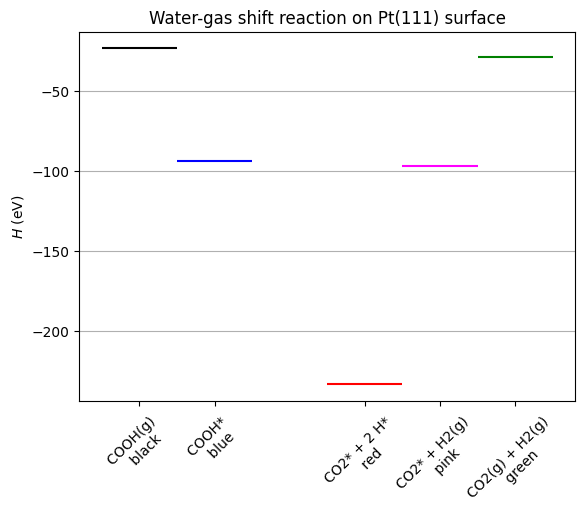

In [40]:
from matplotlib import pyplot as plt

plt.hlines(H_COOH, xmin=0, xmax=1, colors='black')                          # COOH(g)
plt.hlines(H_COOH_Pt111, xmin=1, xmax=2, colors='blue')                    # COOH*
plt.hlines(H_CO2_Pt111 + (2 * H_H_Pt111), xmin=3, xmax=4, colors='red')   # CO2* + 2 H*
plt.hlines(H_CO2_Pt111 + H_H2, xmin=4, xmax=5, colors='magenta')              # CO2* + H2(g)
plt.hlines(H_CO2 + H_H2, xmin=5, xmax=6, colors='green')                    # CO2(g) + H2(g)

plt.ylabel(r'$H$ (eV)')
plt.xticks([0.5, 1.5, 3.5, 4.5, 5.5], ['COOH(g) \n black','COOH* \n blue','CO2* + 2 H* \n red','CO2* + H2(g) \n pink', 'CO2(g) + H2(g) \n green'], rotation=45)
plt.title('Water-gas shift reaction on Pt(111) surface')
plt.grid(axis='y')